# Статистический анализ данных

## Анализ сервиса аренды самокатов GoFast

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.  
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:  
* без подписки  
    - абонентская плата отсутствует;  
    - стоимость одной минуты поездки — 8 рублей;  
    - стоимость старта (начала поездки) — 50 рублей;  
* с подпиской Ultra  
    - абонентская плата — 199 рублей в месяц;  
    - стоимость одной минуты поездки — 6 рублей;  
    - стоимость старта — бесплатно.

Описание данных  
В основных данных есть информация о пользователях, их поездках и подписках. Есть и дополнительная информация — о количестве обращений пользователей в техподдержку сервиса до и после обновления технической инфраструктуры.  
Пользователи — `users_go.csv`   
Поездки — `rides_go.csv`  
Подписки — `subscriptions_go.csv`  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

### Загрузка данных

In [4]:
try:
    data_users = pd.read_csv('/datasets/users_go.csv')
except:
    data_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')

In [5]:
try:
    data_rides = pd.read_csv('/datasets/rides_go.csv')
except:
    data_rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

In [6]:
try:
    data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    data_subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

Выведем первые строки каждого набора данных. Изучим общую информацию о каждом датафрейме.

In [7]:
data_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [8]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [9]:
data_users.describe()

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


Все столбцы заполнены без пропусков.   
Странным значением мне кажется минимальный возраст 12 лет. Если самокат электрический, то их выдают в прокат только с 14 лет.

In [10]:
data_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [11]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [12]:
data_rides.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


Минимальная длительность ровно 0.5 минуты, возможно это автоматическая отмена поездки по какой-то причине?   
Минимальное расстояние меньше метра также странное.  
Пропусков также нет.

In [13]:
data_subscriptions = data_subscriptions.set_index('subscription_type')
data_subscriptions

,minute_price,start_ride_price,subscription_fee
subscription_type,,,
free,8,50,0
ultra,6,0,199


Здесь информация о двух существующих типах подписки.

### Предобработка данных

Приведите столбец date к типу даты Pandas.

In [14]:
data_rides['date'] = pd.to_datetime(data_rides['date'], format='%Y-%m-%d', errors='raise')

In [15]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Создайте новый столбец с номером месяца на основе столбца date.

In [16]:
data_rides['month'] = data_rides['date'].dt.month
data_rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

In [17]:
data_rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [18]:
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Пропусков нет

In [19]:
data_users.duplicated().sum()

31

In [20]:
data_users = data_users.drop_duplicates().reset_index(drop=True)

In [21]:
data_users.duplicated().sum()

0

In [22]:
data_users['user_id'].value_counts()

1       1
1020    1
1029    1
1028    1
1027    1
       ..
510     1
509     1
508     1
507     1
1534    1
Name: user_id, Length: 1534, dtype: int64

Все id встречаются по одному разу, значит дубликатов нет. 

In [23]:
data_rides.duplicated().sum()

0

### Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках

Частота встречаемости городов

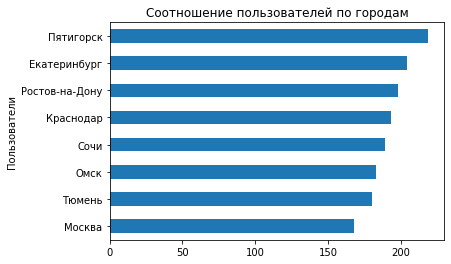

In [24]:
data_users['city'].value_counts().sort_values().plot(kind='barh', 
                                   title='Соотношение пользователей по городам', 
                                   xlabel='Пользователи',
                                   ylabel='Город');

Неожиданно, но в Москве меньше всего пользователей. Интересно, как обстоит дело с числом поездок по городам?

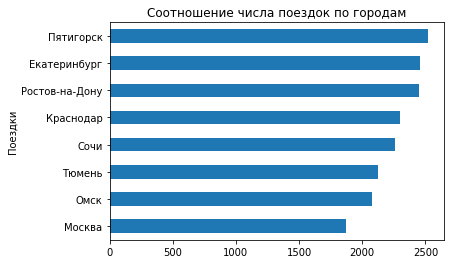

In [25]:
(data_users.merge(data_rides, how='left', on='user_id')['city'].value_counts().
    sort_values().plot(kind='barh', 
                                   title='Соотношение числа поездок по городам', 
                                   xlabel='Поездки',
                                   ylabel='Город'));

Только Тюмень обошла Омск, остальной порядок городов остался таким же.

Соотношение пользователей с подпиской и без подписки;

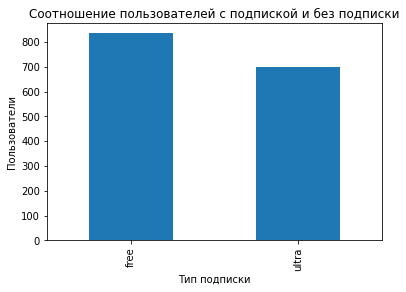

In [26]:
(data_users['subscription_type'].value_counts().
 sort_values(ascending=False).plot(kind='bar', 
                                   title='Соотношение пользователей с подпиской и без подписки', 
                                   xlabel='Тип подписки', 
                                   ylabel='Пользователи'));

Бесплатных подписчиков больше, что ожидаемо.   
Однако всё же платная подписка есть почти у половины пользователей, значит она очень привлекательная для пользователей?

In [27]:
free = data_users['subscription_type'].value_counts()[0]
ultra = data_users['subscription_type'].value_counts()[1]
print('Доля пользователей с подпиской:', round(ultra/(free+ultra),2))
print('Доля пользователей без подписки:', round(free/(free+ultra),2))

Доля пользователей с подпиской: 0.46
Доля пользователей без подписки: 0.54


Возраст пользователей;

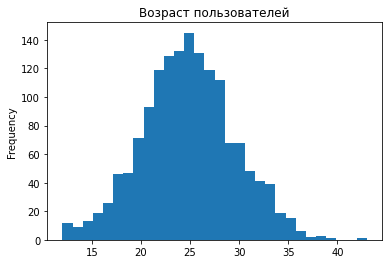

In [28]:
data_users['age'].plot(kind='hist', bins=30, 
                                   title='Возраст пользователей', 
                                   xlabel='Возраст', 
                                   ylabel='Пользователи');

Распределение похоже на нормальное.  
Самый частый возраст - 25 лет.  
все пользователи младше 45 лет и старше 12. Однако наличие 12- и 13-летних пользователей для меня необычно. Хотелось бы узнать у поставщика данных не ошибка ли это. Но пока буду считать, что регистрация возможна с 12 лет.

Расстояние, которое пользователь преодолел за одну поездку;

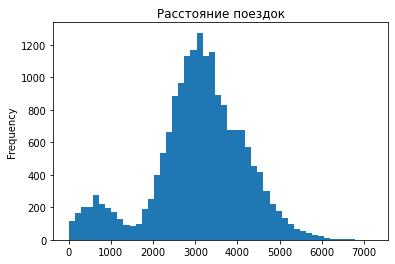

In [29]:
data_rides['distance'].plot(kind='hist', bins=50, 
                                   title='Расстояние поездок', 
                                   xlabel='Расстояние', 
                                   ylabel='Пользователи');

Выделяется два вида поездок: короткие и длинные. Короткие от 0 до 1500м, длинные от 1500 до 7000м.  
Возможно люди с разными подписками совершают разные поездки. Например, на бесплатной подписке короткие поездки очень дорогие из-за платного старта.  
Интересно, что переходные значения между видами поездок в районе 1500м встречаются довольно редко.  
Также выделяется небольшой пик около 4000м.

Продолжительность поездок.

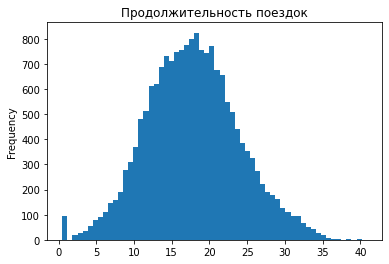

In [30]:
data_rides['duration'].plot(kind='hist', bins=60, 
                                   title='Продолжительность поездок', 
                                   xlabel='Продолжительность', 
                                   ylabel='Пользователи');

Распределение почти нормальное, за исключением всплеска около 0. Проверим, не имеют ли эти поездки длительнось 0.5 минуты, которую мы уже отметили при обзоре данных.

In [31]:
data_rides.loc[data_rides['duration'] == 0.5,'duration'].count()

95

In [32]:
data_rides.loc[data_rides['duration'] < 2,'duration'].count()

95

И правда, все очень короткие поездки длились ровно 0.5 минут. Скорее всего это автоматически отменённые поездки и от них лучше избавиться.

In [33]:
data_rides = data_rides.drop(data_rides[data_rides['duration'] == 0.5].index)

### Объединение данных

Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge().

In [34]:
data = data_users.merge(data_rides, how='left', on='user_id')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


In [35]:
print('Строк было',data_rides.shape[0])
print('Строк стало',data.shape[0])

Строк было 17973
Строк стало 17973


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   distance           17973 non-null  float64       
 6   duration           17973 non-null  float64       
 7   date               17973 non-null  datetime64[ns]
 8   month              17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB


Все строки склеились, пропусков нет.

Создайте ещё два датафрейма из датафрейма: c данными о пользователях без подписки; с данными о пользователях с подпиской.

In [37]:
data_free = data[data['subscription_type'] == 'free']
data_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2


In [38]:
data_ultra = data[data['subscription_type'] == 'ultra']
data_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


##### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

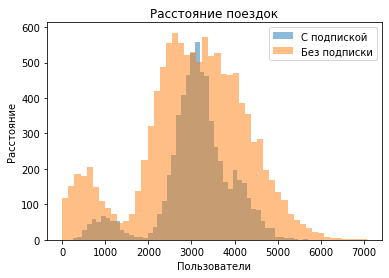

In [39]:
plt.title('Расстояние поездок')
plt.xlabel('Пользователи')
plt.ylabel('Расстояние')
plt.hist(data_ultra.loc[:,['distance']], bins=50, alpha=0.5);
plt.hist(data_free.loc[:,['distance']], bins=50, alpha=0.5);
plt.legend(['С подпиской','Без подписки']);

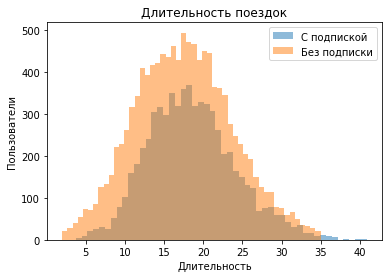

In [40]:
plt.title('Длительность поездок')
plt.xlabel('Длительность')
plt.ylabel('Пользователи')
plt.hist(data_ultra.loc[:,['duration']], bins=50, alpha=0.5);
plt.hist(data_free.loc[:,['duration']], bins=50, alpha=0.5);
plt.legend(['С подпиской','Без подписки']);

Распределение по времени осталось похожим на нормальное в обоих вариантах.  
Похоже, что премиум подписчики реже совершают короткие поездки, хотя для них они совсем недорогие.   
Возможно премиум покупают те, кто совершает длинные поездки.  
Также у премиум подписчиков гораздо более острый пик около 3км и небольшой пик около 4км. У бесплатных подписчиков рассстояние от 2 до 4 км распределено более равномерно.

Вообще странно, что длительность распределена нормально, в то время как расстояние имеет два вида. Проведём небольшое исследование скорости поездок.

In [41]:
test = data.loc[:, ['distance', 'duration','date']].copy()

In [42]:
test['speed'] = test['distance'] / test['duration'] / 1000 * 60

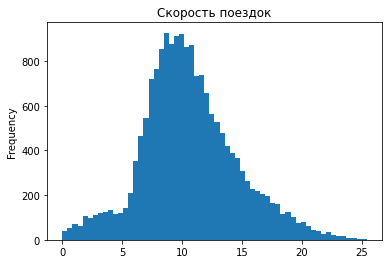

In [43]:
test['speed'].plot(kind='hist', bins=60, 
                                   title='Скорость поездок', 
                                   xlabel='Скорость', 
                                   ylabel='Пользователи');

Больше похоже на распределение расстояний, посмотрим отдельно на скорости коротких и длинных поездок.

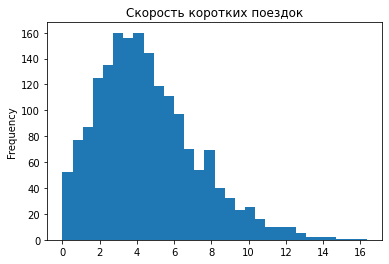

In [44]:
test.loc[test['distance'] < 1500,'speed'].plot(kind='hist', bins=30, 
                                   title='Скорость коротких поездок', 
                                   xlabel='Скорость', 
                                   ylabel='Пользователи');

In [45]:
test.loc[test['distance'] < 1500,'speed'].median().round(2)

4.18

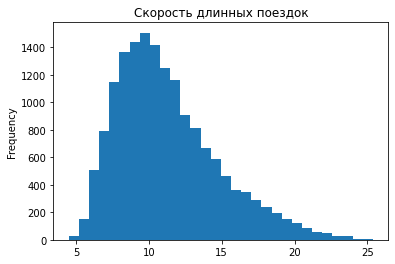

In [46]:
test.loc[test['distance'] >= 1500,'speed'].plot(kind='hist', bins=30, 
                                   title='Скорость длинных поездок', 
                                   xlabel='Скорость', 
                                   ylabel='Пользователи');

In [47]:
test.loc[test['distance'] >= 1500,'speed'].median().round(2)

10.63

Большинство коротких поездок совершалось со средней скоростью ниже 10км/ч, медианная скорость 4.18км/ч.   
А вот длинные, почти все быстрее 5км/ч, медианная скорость 10.63км/ч.

Вспомним, что оплата происходит поминутно и не зависит от проделанного пути. Поэтому логично, что нормальное распределение именно у времени поездки.  
А вот расстояние и скорость есть разные. Есть те, кто в среднем не разгоняется выше 5км/ч и те кто катается побыстрее. И чем выше скорость, тем большее расстояние человек проезжает.

### Подсчёт выручки

Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [48]:
data_pivot = data.pivot_table(index=['user_id', 'month'], 
                 values=['distance','duration','subscription_type'], 
                 aggfunc={
                     'subscription_type': 'first',
                     'distance' : 'sum',
                     'duration': ['sum', 'count']
                 })
data_pivot.columns = ['distance_sum', 'number_of_rides', 'duration_sum','subscription_type']
data_pivot = data_pivot.reset_index()
data_pivot.head()

,user_id,month,distance_sum,number_of_rides,duration_sum,subscription_type
0,1,1,7027.511294,2,41.416640,ultra
1,1,4,754.159807,1,6.232113,ultra
2,1,8,6723.470560,2,44.776802,ultra
3,1,10,5809.911100,2,31.578017,ultra
4,1,11,7003.499363,3,53.397424,ultra


В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь — обратитесь к информации об условиях оплаты для подписчиков и и тех, у кого нет подписки. Минуты при подсчёте стоимости округляются до ближайшего целого числа.

In [49]:
def revenue(row):
    subscription_type = data_users.loc[data_users['user_id'] == row['user_id'],'subscription_type'].iloc[0]
    subscription_fee = data_subscriptions.loc[subscription_type,'subscription_fee']
    minute_price = data_subscriptions.loc[subscription_type,'minute_price']
    start_ride_price = data_subscriptions.loc[subscription_type,'start_ride_price']
    return subscription_fee + start_ride_price*row['number_of_rides'] + minute_price*round(row['duration_sum'],0)
data_pivot['revenue'] = data_pivot.agg(axis=1, func=revenue)

In [50]:
data_pivot.head()

,user_id,month,distance_sum,number_of_rides,duration_sum,subscription_type,revenue
0,1,1,7027.511294,2,41.416640,ultra,445.0
1,1,4,754.159807,1,6.232113,ultra,235.0
2,1,8,6723.470560,2,44.776802,ultra,469.0
3,1,10,5809.911100,2,31.578017,ultra,391.0
4,1,11,7003.499363,3,53.397424,ultra,517.0


### Проверка гипотез

Время поездок

6.1  Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то действительно ли пользователи с подпиской «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

$H_0$: средние значения длительности поездок равны.  
$H_1$: среднее значение длительности поездок пользователей с подпиской больше, чем среднее значение длительности поездок пользователей без подписки

In [51]:
alpha = 0.01
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.704468074453899e-28
Отвергаем нулевую гипотезу


У платных пописчиков средняя длительность поездки выше.

In [52]:
# Проверим точные значения, так как выборка достаточно маленькая
print('Среднее с подпиской:', data_ultra['duration'].median())
print('Среднее без подписки:', data_free['duration'].median())

Среднее с подпиской: 18.17815320055055
Среднее без подписки: 17.383807372851628


Цена 18-минутной поездки с подпиской равна 18*6 = 108 рублей.  
Цена 17-минутной поездки без подписки равна 50 + 17*8 = 186 рублей.  
Таким образом бесплатные пользователи выгоднее.  
Чтобы проверить это не зная точное значение медианы проведём ещё одно исследование.

$H_0$: средние цены поездок равны.  
$H_1$: средняя цена поездки пользователей с подпиской ниже, чем средняя цена поездки пользователей без подписки

In [53]:
alpha = 0.01
results = st.ttest_ind((data_ultra['duration']*6), (50+data_free['duration']*8), alternative='less')
print('p-значение:', results.pvalue)
if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.0
Отвергаем нулевую гипотезу


Платные подписчики невыгодны, но тут не учитывается цена подписки. Так что следует сравнивать ежемесячный доход.

Исследуем среднее значение revenue.

In [54]:
data_revenue_sum = data_pivot.loc[:,['revenue','number_of_rides','subscription_type']].groupby('subscription_type').sum()
data_revenue_sum

,revenue,number_of_rides
subscription_type,,
free,2182514.0,11473
ultra,1625253.0,6500


In [55]:
free_revenue_mean = data_revenue_sum.loc['free','revenue'] / data_revenue_sum.loc['free','number_of_rides']
ultra_revenue_mean = data_revenue_sum.loc['ultra','revenue'] / data_revenue_sum.loc['ultra','number_of_rides']
print('Средняя выручка за поездку без подписки', free_revenue_mean.round(2))
print('Средняя выручка за поездку с подпиской', ultra_revenue_mean.round(2))

Средняя выручка за поездку без подписки 190.23
Средняя выручка за поездку с подпиской 250.04


Пользователь с подпиской всё таки выгоднее.

Неучтённая стоимось подписки сильно изменила значения. Я подумала что пользователи, купившие подписку катаются хотя бы неслько раз в месяц. И тогда влияние цены подписки на цену поездки не было бы столь значительным.  
Это мне урок о том, что между "я подумала" и "на самом деле" может быть большая разница и все мысли обязательно надо проверять.

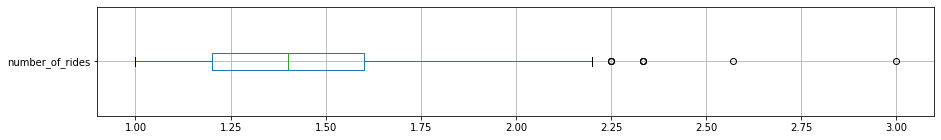

In [56]:
(data_pivot.loc[data_pivot['subscription_type'] == 'ultra',['user_id','number_of_rides']]
 .groupby('user_id').mean()
 .boxplot(vert = False,figsize = (15,2)));

Медианное значение числа поездок в месяц у платных подписчков меньше 1.5, а наибольшее значение всего 3. Отсюда такое сильное влияние цены подписки на цену поездки.

Расстояние поездок

6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров? Проверьте гипотезу и сделайте выводы.

$H_0$ Средняя поездка у пользователей с подпиской равна 3130 метра.   
$H_1$ Средняя поездка у пользователей с подпиской меньше 3130 метра.

In [57]:
alpha = 0.05
results = st.ttest_1samp(data_ultra['distance'], 3130, alternative='less')
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.08046311521502146
Не отвергаем нулевую гипотезу


Расстояние, которое проезжают пользователи с подпиской за одну поездку, не меньше 3130 метров. 

Выручка с подписок

6.3. Проверьте гипотезу о том, будет ли выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки. Сделайте вывод.

$H_0$ Выручка от пользователей с подпиской равна выручке от пользователей без подписки.  
$H_1$ Выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

In [58]:
alpha = 0.01
ultra_revenue = data_pivot.loc[data_pivot['subscription_type']=='ultra','revenue']
free_revenue = data_pivot.loc[data_pivot['subscription_type']=='free','revenue']

results = st.ttest_ind(ultra_revenue, free_revenue, alternative='greater')

print('p-значение:', results.pvalue)
if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 3.896683338141335e-36
Отвергаем нулевую гипотезу


Выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

Обновление приложения

6.4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

$H_0$ Количество обращений в техподдержку не изменилось.  
$H_1$ Количество обращений в техподдержку значимо снизилось.  

In [59]:
before = [1, 2, 3] #значения до изменений
after = [2, 3, 4] #значения после изменений

alpha = 0.05

results = st.ttest_rel(before, after, alternative= 'greater') # тест для зависимых выборок

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


/tmp/ipykernel_31/3857148275.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results = st.ttest_rel(before, after, alternative= 'greater') # тест для зависимых выборок


### Распределения (необязательное задание)

##### Акция на беспланый месяц

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Построим график вероятности получить меньше 100 подписок для различного числа купонов. На этом графике мы хотим найти значение 0.05.
Распределение аппроксимируем нормальным.

Text(0, 0.5, 'Вероятность')

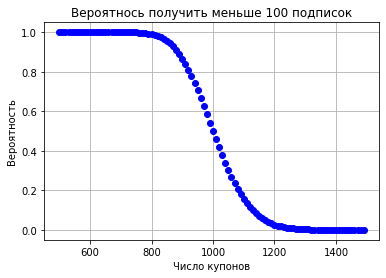

In [60]:
from math import sqrt

p = 0.1

result = []

for n in range(500, 1500, 10):
    mu = n*p
    sigma = sqrt(n * p * (1 - p))
    distr = st.norm(mu, sigma) 
    result.append(distr.cdf(100))

plt.grid(zorder=0)
plt.plot(range(500, 1500, 10),result, 'bo');
plt.title('Вероятнось получить меньше 100 подписок')
plt.xlabel('Число купонов')
plt.ylabel('Вероятность')

Нужное значение где-то около 1200.

Text(0, 0.5, 'Вероятность')

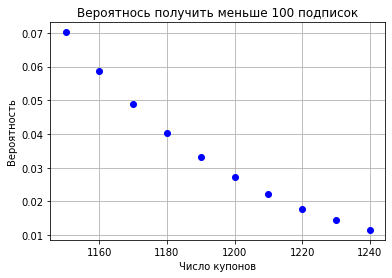

In [61]:
result = []
n_range = range(1150, 1250, 10)
for n in n_range:
    mu = n*p
    sigma = sqrt(n * p * (1 - p))
    distr = st.norm(mu, sigma) 
    result.append(distr.cdf(100))
    
plt.grid(zorder=0)
plt.plot(n_range, result, 'bo');
plt.title('Вероятнось получить меньше 100 подписок')
plt.xlabel('Число купонов')
plt.ylabel('Вероятность')

Text(0, 0.5, 'Вероятность')

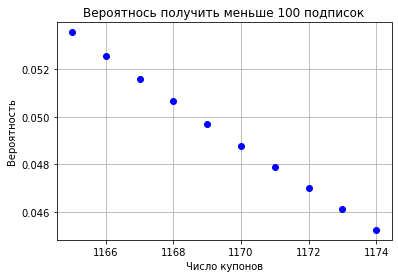

In [62]:
result = []
n_range = range(1165, 1175, 1)
for n in n_range:
    mu = n*p
    sigma = sqrt(n * p * (1 - p))
    distr = st.norm(mu, sigma) 
    result.append(distr.cdf(100))
    
plt.grid(zorder=0)
plt.plot(n_range, result, 'bo');
plt.title('Вероятнось получить меньше 100 подписок')
plt.xlabel('Число купонов')
plt.ylabel('Вероятность')

In [63]:
n = 1169
mu = n*p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma) 

result = distr.cdf(100)
print('Если разослать', n, 'промокодов, то вероятность получить меньше 100 пописок =', result.round(4))

Если разослать 1169 промокодов, то вероятность получить меньше 100 пописок = 0.0497


Смотреть на графики как-то неудобно, особенно если мы хотим точное значение. Гораздо логичнее было бы задать изначальные рамки, например 100 и 2000 купонов. А затем провести двоичный поиск, так как функция не возрастает и значения отсортированы.

##### Push-уведомления 

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Text(0, 0.5, 'Вероятность')

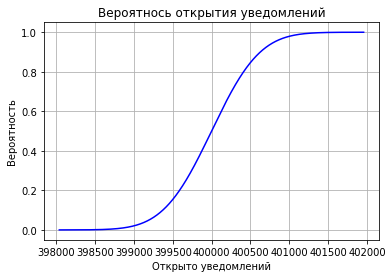

In [64]:
from scipy.stats import norm
n = 1000000
p = 0.4
mu = n*p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma) 

left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
x = list(range(max(0, left), right))

plt.grid(zorder=0)
plt.plot(x, norm.cdf(x, mu, sigma), 'b-');
plt.title('Вероятнось открытия уведомлений')
plt.xlabel('Открыто уведомлений')
plt.ylabel('Вероятность')

In [65]:
distr.cdf(399500)

0.15371708296369768

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей примерно равна 15%.

### Вывод

Предоставленные данные без пропусков и почти без выбросов.  
В данных присутствуют записи об автоматически отменённых поездках, длительностью ровно 30 секунд. Такие поездки следует исключить из датасета.  
Минимальный возраст пользователя 12 лет. Следует уточнить, реальное ли это значение.  
В данных присутствовало несколько дубликатов пользователей, которые были удалены.  

Больше всего пользователей зарегистрировано в Пятигорске, а меньше всего в Москве.  
Пользователей без подписки больше, чем пользователей с попиской, но не на много. Пописка есть у 46% пользователей.  
Возраст пользователей распределён нормально. Самый частый возраст - 25 лет. Диапазон значений от 12 до 45 лет.  
По расстоянию поездки можно разделить на два вида: короткие и длинные. Короткие от 0 до 1500м, длинные от 1500 до 7000м. Переходные значения между видами поездок в районе 1500м встречаются довольно редко.  
Длительность поездок распределена нормально самое частое значение 15-20 минут. Все поездки были не дольше 45 минут.  

Если рассматривать отдельно пользователей с подпиской и без неё, то распределение времени останется похожим на нормальное в обоих вариантах. Но премиум подписчики реже совершают короткие поездки, хотя для них они совсем недорогие.  

После проверки гипотез были получены следующие выводы:
* У платных пописчиков средняя длительность поездки выше.
* Расстояние, которое проезжают пользователи с подпиской за одну поездку, не меньше 3130 метров.
* Выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

Если разослать 1169 промокодов, то вероятность получить меньше 100 пописок = 0.0497.  
Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей примерно равна 15%.  